In [1]:
from pathlib import Path
from chapp import ppopen
from chapp.blockcomb import BlockCombinationProcessor, BlockCombParams, BlockCombSimulator
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from loguru import logger

logger.disable('chapp')

workpath = Path("~/Work/CAPP8TB6G/BlockCombinationPlaybook").expanduser()
preprocpath = Path("~/Work/CAPP8TB6G/preprocess/hep1-2_pp1s6c.nc").expanduser()
wfpath = Path("~/Work/CAPP8TB6G/8TB6G_WFBANK.nc").expanduser()
blkcpath = workpath / 'testproc.nc'

# blkcpath.unlink()


bfield = 6.965
volume = 3.103e-3


if not workpath.exists():
    workpath.mkdir()

    
ppr = ppopen(
    preprocpath,
    chunks={"grunstep": 5},
    sel={"grunstep": slice(520, 580)},
    name_map={"gmsqr": "gmsqr2"},
    _bfield=bfield,
    _volume=volume,
)


fsc = ppr.cavds.fsc.compute()
fsc0 = 5.8386128e9
fscexact = fsc.data[np.argmin(np.abs(fsc.data - fsc0))]
f_fa1 = fscexact - 4000  # snr peak
f_fa2 = fscexact + 4000  # snr valley

# grunstep index at which snr peak occurs for f_fa1
grs_fa1_idx = 33

# i am focusing on the snr peak regions
focusregion = slice(f_fa1 - 100e3, f_fa1 + 100e3)


try:
    blkcs = BlockCombSimulator.make(ppr, blkcpath, shapefa=5.9e9)
except FileNotFoundError:
    params = BlockCombParams(n_reb=10, n_blk=20, ndrop=5, wfpath=wfpath, wf_fa=5.9e9, rebin_sbsym=True, mask_waveform_mirror=True)
    blkc = BlockCombinationProcessor.make(ppr, params)
    blkc.prepare()
    gds = blkc.process()
    gds.to_netcdf(blkcpath, mode='w')
    blkc.save_prep(blkcpath)
    blkcs = BlockCombSimulator.make(ppr, blkcpath, shapefa=5.9e9)
finally:
    blkcs.prepare()
    gds = xr.open_dataset(blkcpath)
    

def vline(x, ax, color):
    ax.vlines(x, 0, 1, transform=ax.get_xaxis_transform(), color=color)

[WARNING] Using bfield as 6.965, ignoring what's inside the 'bfield' group.
[WARNING] Using volume as 0.003103, ignoring what's inside cavds.


In [5]:
sig = blkcs.generate_signal_delta([f_fa1]).compute()
noise = blkcs.generate_noise_delta()

In [12]:

grs_fa1_idx = 33

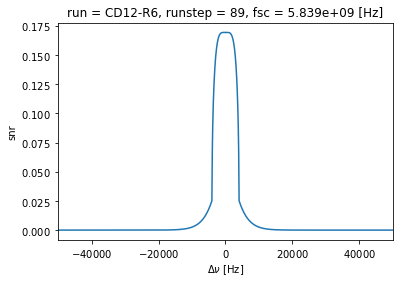

In [16]:
sig.isel(grunstep=33).plot(x='dnu', hue='grunstep', xlim=(-50e3, 50e3));

# Auxiliary Plots

## Injected Signal Frequencies

Text(0.5, 1.0, 'SNR Spectrum and the Fake Signal Frequencies')

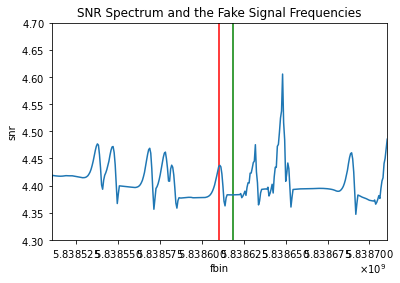

In [4]:
%matplotlib inline
fig, ax = plt.subplots()
gds.snr.plot(ax=ax)
ax.vlines([f_fa1], 0, 1, transform=ax.get_xaxis_transform(), color='r')
ax.vlines([f_fa2], 0, 1, transform=ax.get_xaxis_transform(), color='g')
ax.set_xlim((f_fa1 - 100e3, f_fa1 + 100e3))
ax.set_ylim((4.3, 4.7))
ax.set_title("SNR Spectrum and the Fake Signal Frequencies")